In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


trainset_torch = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
testset_torch = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)
trainloader_torch = DataLoader(trainset_torch, batch_size=64, shuffle=True)
testloader_torch = DataLoader(testset_torch, batch_size=64, shuffle=False)


(trainset_tf, testset_tf), ds_info = tfds.load('svhn_cropped', split=['train', 'test'], as_supervised=True, with_info=True)
def preprocess_tf(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalisasi
    return image, label

trainset_tf = trainset_tf.map(preprocess_tf).shuffle(10000).batch(64)
testset_tf = testset_tf.map(preprocess_tf).batch(64)

100%|██████████| 182M/182M [00:20<00:00, 9.09MB/s]
100%|██████████| 64.3M/64.3M [00:15<00:00, 4.02MB/s]


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.AAAAGZ_3.1.0/svhn_cropped-train.tfrecord*...:   0%…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.AAAAGZ_3.1.0/svhn_cropped-test.tfrecord*...:   0%|…

Generating extra examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.AAAAGZ_3.1.0/svhn_cropped-extra.tfrecord*...:   0%…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.1.0. Subsequent calls will reuse this data.


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)  # Input: 3 channels (RGB), Output: 32 filters
        self.pool = nn.MaxPool2d(2, 2)    # Pooling 2x2
        self.conv2 = nn.Conv2d(32, 64, 3) # Input: 32, Output: 64
        self.fc1 = nn.Linear(64 * 6 * 6, 128)  # Fully connected layer (SVHN: 32x32 -> 6x6 setelah pooling)
        self.fc2 = nn.Linear(128, 10)     # Output: 10 kelas (0-9)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 6 * 6)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [ ]:
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

mlp_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
def train_cnn(epochs=10):
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader_torch, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader_torch):.3f}, Accuracy: {100 * correct / total:.2f}%')

train_cnn(epochs=10)

mlp_model.fit(trainset_tf, epochs=10, validation_data=testset_tf)

Epoch 1, Loss: 0.802, Accuracy: 75.85%
Epoch 2, Loss: 0.436, Accuracy: 87.56%
Epoch 3, Loss: 0.356, Accuracy: 89.71%
Epoch 4, Loss: 0.305, Accuracy: 91.12%
Epoch 5, Loss: 0.267, Accuracy: 92.22%
Epoch 6, Loss: 0.237, Accuracy: 93.09%
Epoch 7, Loss: 0.207, Accuracy: 93.97%
Epoch 8, Loss: 0.184, Accuracy: 94.55%
Epoch 9, Loss: 0.162, Accuracy: 95.14%
Epoch 10, Loss: 0.144, Accuracy: 95.59%
Epoch 1/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.2117 - loss: 2.2029 - val_accuracy: 0.4184 - val_loss: 1.7140
Epoch 2/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.5002 - loss: 1.4726 - val_accuracy: 0.5441 - val_loss: 1.4255
Epoch 3/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5756 - loss: 1.3097 - val_accuracy: 0.5290 - val_loss: 1.4944
Epoch 4/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.6013 - loss: 1.2391 - val_accuracy: 0.5947 - val_loss: 1.3204
Epoch 5/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.6219 - loss


Evaluasi CNN:
Akurasi: 0.8859
Presisi: 0.8825
Recall: 0.8696
F1-Score: 0.8749
AUC: 0.9879
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/s

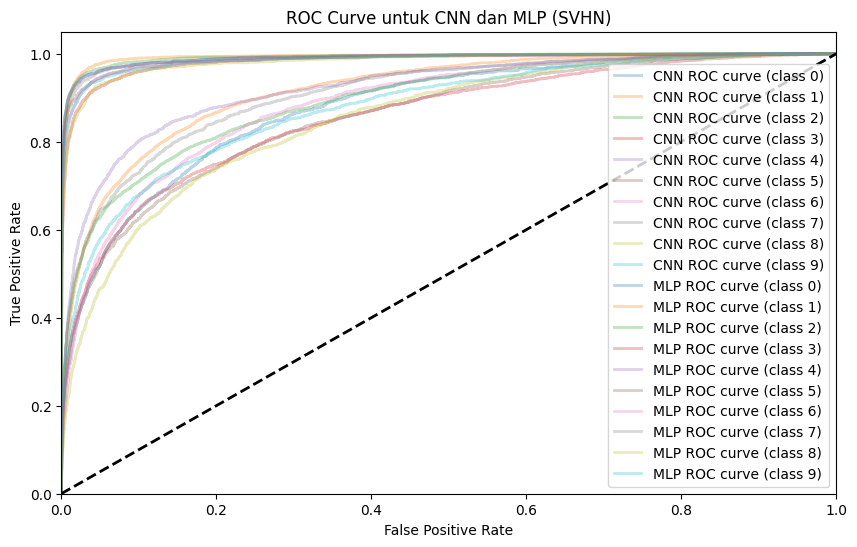

In [7]:
# Fungsi untuk menghitung metrik evaluasi
def evaluate_model(true_labels, pred_labels, pred_probs, model_name):
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, average='macro')
    rec = recall_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')
    auc = roc_auc_score(true_labels, pred_probs, multi_class='ovr')

    print(f"\nEvaluasi {model_name}:")
    print(f"Akurasi: {acc:.4f}")
    print(f"Presisi: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    return acc, prec, rec, f1, auc

# Evaluasi CNN (PyTorch)
cnn_model.eval()
true_labels_cnn = []
pred_labels_cnn = []
pred_probs_cnn = []
with torch.no_grad():
    for data in testloader_torch:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = cnn_model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        _, predicted = torch.max(outputs.data, 1)
        true_labels_cnn.extend(labels.cpu().numpy())
        pred_labels_cnn.extend(predicted.cpu().numpy())
        pred_probs_cnn.extend(probs)

cnn_metrics = evaluate_model(true_labels_cnn, pred_labels_cnn, pred_probs_cnn, "CNN")

# Evaluasi MLP (TensorFlow)
true_labels_mlp = []
pred_labels_mlp = []
pred_probs_mlp = []
for images, labels in testset_tf:
    probs = mlp_model.predict(images)
    predicted = np.argmax(probs, axis=1)
    true_labels_mlp.extend(labels.numpy())
    pred_labels_mlp.extend(predicted)
    pred_probs_mlp.extend(probs)

mlp_metrics = evaluate_model(true_labels_mlp, pred_labels_mlp, pred_probs_mlp, "MLP")

# Visualisasi ROC Curve untuk CNN dan MLP
plt.figure(figsize=(10, 6))
n_classes = 10
colors = ['b', 'r']

for model_name, true_labels, pred_probs in [("CNN", true_labels_cnn, pred_probs_cnn), ("MLP", true_labels_mlp, pred_probs_mlp)]:
    true_labels_bin = label_binarize(true_labels, classes=range(n_classes))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(true_labels_bin[:, i], np.array(pred_probs)[:, i])
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'{model_name} ROC curve (class {i})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve untuk CNN dan MLP (SVHN)')
plt.legend(loc="lower right")
plt.show()